In [1]:
import torch
import sys
import pylab as plt

sys.path.append('/home/john/Dropbox/code/Notebook/Pytorch_Patch_Based/')
from Model.PatchCNN import PatchCNN

model = PatchCNN()
state_dict = torch.load('/mnt/DATA_CRLM/Patches/Checkpoints/PatchCNN/PatchCNN_224/PatchCNN_best.pth')
new_state_dict = {}
for key in model.state_dict():
    new_state_dict[key] = state_dict['module.'+key].double()
model.load_state_dict(new_state_dict)
model.eval()
model.cuda()

PatchCNN(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

(536, 552)


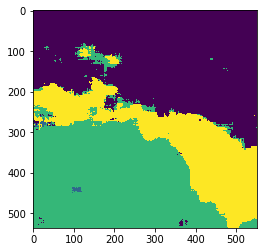

In [3]:
device = torch.device("cuda:0")
model.to(device)
index='m80'
import numpy as np
test_img = plt.imread('/mnt/DATA_CRLM/SShot/im_'+index+'.png')

step = 14
patch_size = 224

nx = len(range(0,test_img.shape[0]-patch_size,step))
ny = len(range(0,test_img.shape[1]-patch_size,step))

final_result = torch.zeros((nx*2,ny*2))


for x in range(0,test_img.shape[0]-patch_size,step):
    for y in range(0,test_img.shape[1]-patch_size,step):
        
        test_tensor = torch.from_numpy(((test_img[x:x+patch_size,y:y+patch_size,(2,1,0)]-\
                                        np.array([0.485, 0.456, 0.406]))/ np.array([0.229, 0.224, 0.225])).transpose(2,0,1)).float()

        test_tensor = test_tensor.unsqueeze(0)
        
        out = model(test_tensor.cuda())
        softmax = torch.nn.Softmax2d()
        out2 = softmax(out)

        a,r = torch.max(out2[:,(0,2,3,4),:,:],1)
        #print out2.shape
        #print(a.size(),r.size())
        #rr = copy.copy(r.detach().cpu().numpy())

        final_result[(x/step)*2:(x/step)*2+2,(y/step)*2:(y/step)*2+2] = r[0]

fr = final_result.detach().cpu().numpy()
print(fr.shape)
plt.imshow(fr)
plt.show()
np.save('/mnt/DATA_CRLM/SShot/im_'+index+'_pcnn_label.npy',fr)

torch.Size([3, 3964, 138, 224])
torch.Size([3, 134, 138, 224, 224])
torch.Size([134, 138, 3, 224, 224])
torch.Size([18492, 3, 224, 224])


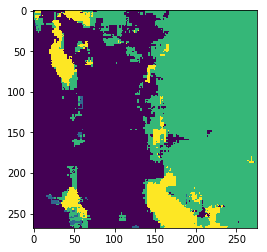

In [5]:
index='m82'
import numpy as np
test_img = plt.imread('/mnt/DATA_CRLM/SShot/im_'+index+'.png')
if test_img.max()>2:
    test_img = test_img/255.0
    
step = 28
patch_size = 224
tt = torch.from_numpy(((test_img[:,:,(2,1,0)]-np.array([0.485, 0.456, 0.406]))/ np.array([0.229, 0.224, 0.225])).transpose(2,0,1)).float()
ta =tt.unfold(2,patch_size,step)
print(ta.size())
tb = ta.unfold(1,patch_size,step)
print(tb.size())
tc = tb.permute((1,2,0,3,4))
print(tc.shape)
td = tc.reshape(-1,3,patch_size,patch_size)
print(td.shape)
nx = len(range(0,test_img.shape[0]-patch_size,step))
ny = len(range(0,test_img.shape[1]-patch_size,step))

final_tensor = td
final_result2 = []


for i in range(nx):
    test_tensor = final_tensor[i*ny:i*ny+ny]
    out = model(test_tensor.cuda())
    softmax = torch.nn.Softmax2d()
    out2 = softmax(out)
    final_result2.append(out2.detach().cpu().numpy())
    
t = np.array(final_result2).transpose(0,3,1,4,2).reshape(nx*2,ny*2,11)

plt.imshow(np.argmax(t[:,:,(0,2,3,4)],2))
plt.show()
np.save('/mnt/DATA_CRLM/SShot/im_'+index+'_pcnn_label.npy',t)